In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from osgeo import gdal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Colormap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline import load as pipeline
from reproduction.analysis import AEData, plot_cluster_channel_distributions, plot_cluster_samples

/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/clouds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [67]:
from tensorflow.keras.applications.densenet import DenseNet121
densenet = DenseNet121(include_top=False)

In [60]:
model_dir = "../output/mod09cnn14/"

with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")

In [3]:
def filename_contains_fn(substr):
    def fn (fnames, _, __):
        return tf.py_func(lambda fname: substr in str(fname), [fnames[0]], tf.bool, False)
    return fn

In [4]:
def load_data(data_glob):
    return  pipeline.load_data(
        data_glob,
        shape=(128, 128, 7),
        batch_size=32,
        read_threads=4,
        shuffle_buffer_size=100,
        prefetch=2
    )

In [5]:
open_cells = load_data("../data/closed-recs/*")
closed_cells = load_data("../data/open-recs/*")

# Open vs Closed Cell Stratocumulus

In [6]:
fields = ["b%d"%(i+1) for i in range(7)]
n_test = 100
n_train = 2000
n = n_train + n_test

In [8]:
opens = AEData(open_cells, ae=ae, n=n)
closeds = AEData(closed_cells, ae=ae, n=n)

In [9]:
for d in (opens, closeds):
    nuniq = len(set((*a, b) for a, b in zip(d.coords, d.names)))
    assert nuniq == n_test + n_train

In [16]:
def fit_classifier(features):
    fitted = classifier.fit(
        X=np.concatenate([features[:n_train], features[n:n+n_train]]),
        y=[0] * n_train + [1] * n_train
    )


    print("accuracy:", fitted.score(
        X=np.concatenate([features[n_train:n], features[n + n_train:]]),
        y=[0] * n_test + [1] * n_test,
    ))

    pred = fitted.predict(np.concatenate([features[n_train:n], features[n+n_train:]]))
    false_closeds = opens.imgs[n_train:n_train + n_test][pred[:n_test] != 0]
    false_opens = closeds.imgs[n_train:n_train + n_test][pred[n_test:] != 1]

    return fitted, false_opens, false_closeds
    
    
def plot_examples(imgs, nrows, ncols, channel=0, width=2):
    _, ax = plt.subplots(nrows, ncols, figsize=(ncols * width, nrows * width))

    for i, a in enumerate(ax.ravel()):
        if i < imgs.shape[0]:
            a.imshow(imgs[i, :, :, channel], cmap="bone")
        a.set_xticks([])
        a.set_yticks([])
    plt.tight_layout()

In [17]:
classifier = SVC(kernel="poly")

In [40]:
def cmap_and_normalize(imgs, reds=[1, 4, 5, 6], greens=[0], blues=[2, 3]):

    ii = np.stack([imgs[:,:,:,col].mean(axis=3) for col in (reds, greens, blues)], axis=3)

    colors = []
    for col in (reds, greens, blues):
        ii = imgs[:, :, :, col].mean(axis=3)
        ii = np.clip(ii, *np.percentile(ii, [0, 99]))
        ii /= (ii.max() - ii.min())
        ii -= ii.min()
        colors.append(ii)

    return np.stack(colors, axis=3)

In [70]:
opens.raw_encs_dn = model.predict(cmap_and_normalize(opens.imgs))
opens.encs_dn = opens.raw_encs_dn.mean(axis=(1,2))

closeds.raw_encs_dn = model.predict(cmap_and_normalize(closeds.imgs))
closeds.encs_dn = closeds.raw_encs_dn.mean(axis=(1,2))

## Baseline: Using only patch mean and stdev

In [23]:
base_features = np.stack([ 
    np.concatenate([opens.imgs.mean(axis=(1,2,3)), closeds.imgs.mean(axis=(1,2,3))]),
    np.concatenate([opens.imgs.std(axis=(1,2,3)), closeds.imgs.std(axis=(1,2,3))])
], axis=1)

base_classifier, fo, fc = fit_classifier(base_features)

accuracy: 0.755


In [24]:
fc.shape, fo.shape

((17, 128, 128, 7), (32, 128, 128, 7))

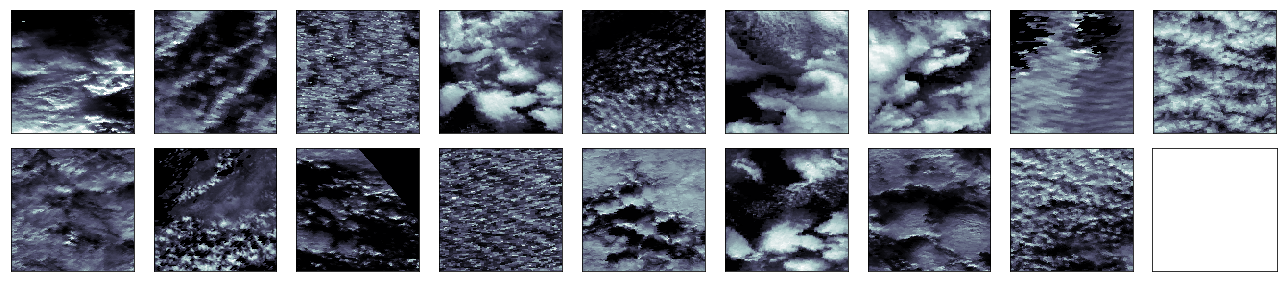

In [25]:
plot_examples(fc, nrows=2, ncols=9)

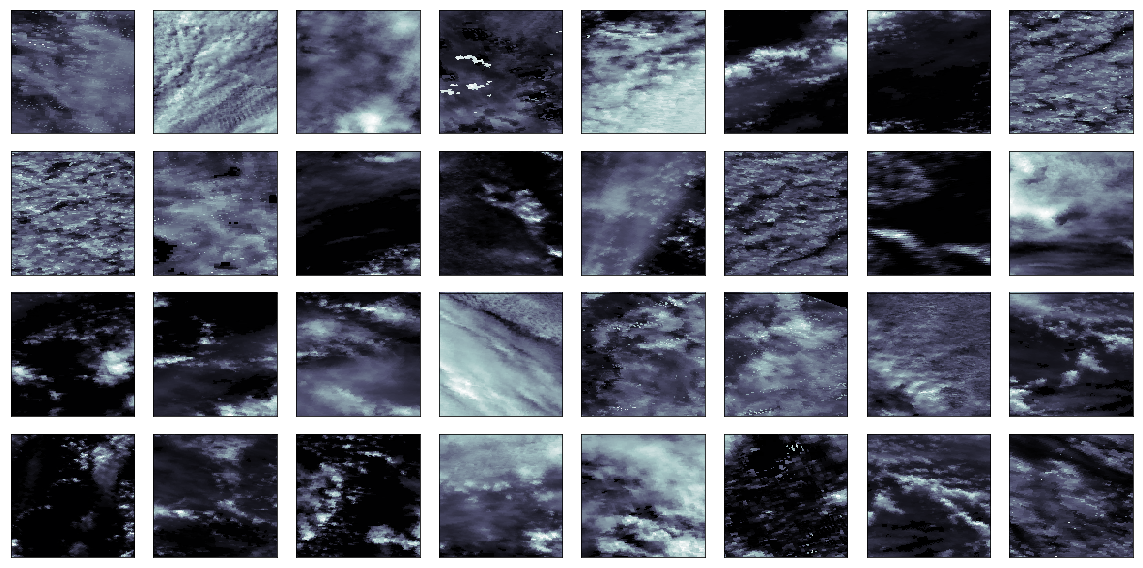

In [27]:
plot_examples(fo, nrows=4, ncols=8)

## Spatially Averaged AE features

In [93]:
ofeat = opens.encs
cfeat = closeds.encs
sae_feat = np.concatenate([ofeat[:n], cfeat[:n]])

sae_classifier, fo, fc = fit_classifier(sae_feat)
fo.shape, fc.shape

accuracy: 0.915


((7, 128, 128, 7), (10, 128, 128, 7))

### Data: "Open", Classifier: "Closed"

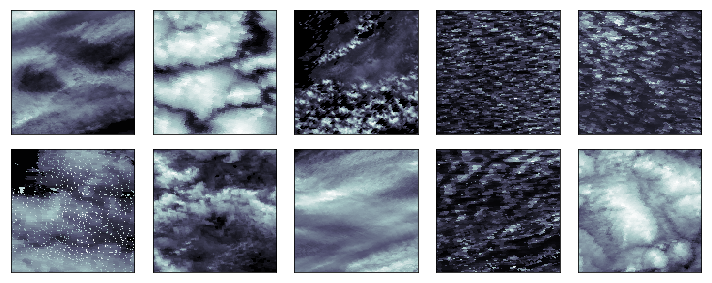

In [90]:
plot_examples(fc, nrows=2, ncols=5)

### Data: "Closed",  Classifier: "Open"

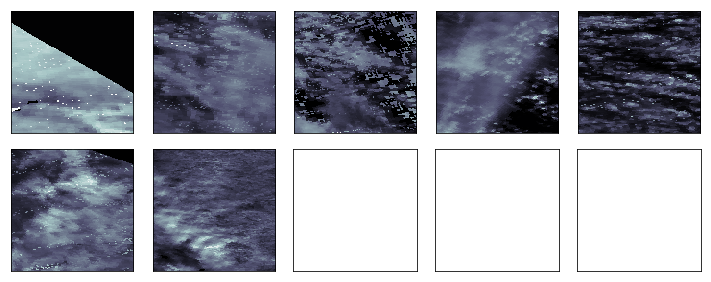

In [91]:
plot_examples(fo, nrows=2, ncols=5)

## DenseNet features

In [ ]:
if False:
    opens.raw_encs_dn = model.predict(cmap_and_normalize(opens.imgs))
    opens.encs_dn = opens.raw_encs_dn.mean(axis=(1,2))

    closeds.raw_encs_dn = model.predict(cmap_and_normalize(closeds.imgs))
    closeds.encs_dn = closeds.raw_encs_dn.mean(axis=(1,2))

In [94]:
dn_feat = np.concatenate([ofeat[:n], cfeat[:n]])

dn_classifier, dn_fo, dn_fc = fit_classifier(sae_feat)
dn_fo.shape, dn_fc.shape

accuracy: 0.915


((7, 128, 128, 7), (10, 128, 128, 7))

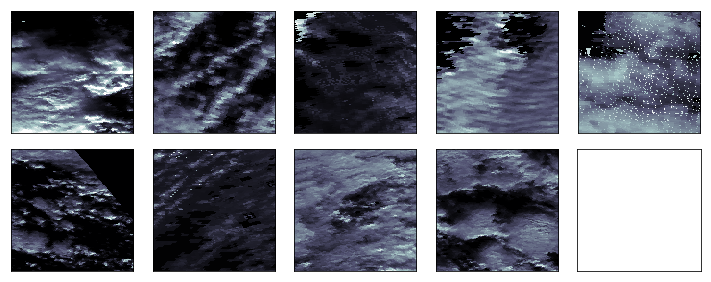

In [85]:
plot_examples(dn_fc, nrows=2, ncols=5)

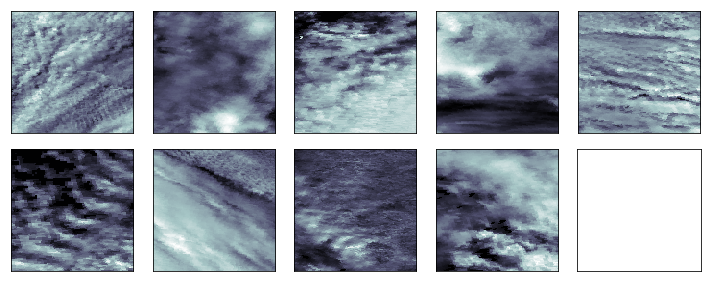

In [86]:
plot_examples(dn_fo, nrows=2, ncols=5)

## Top `d` Principle Components of spatial mean AE features


In [111]:
data = AEData(
    dataset=pipeline.load_data(
        data_glob="../data/tif/*.tfrecord",
        shape=(128, 128, 7),
        batch_size=32,
        read_threads=4,
        shuffle_buffer_size=100,
        prefetch=2
    ),
    ae=ae,
    fields=["b%d"%(i+1) for i in range(7)],
    n=1000
)

In [112]:
d = 64

In [ ]:
_features = np.concaten› ate([
    data.pca_project(opens, d).T,
    data.pca_project(closeds, d).T
])

ae3 = classifier.fit(
    X=np.concatenate([
        _features[:n_train],
        _features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train)
)

ae3.score(
    X=np.concatenate([_features[n_train:n], _features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

Rotating into principle component axis improves things a bit, I think its because the L1 regularization is axis aligned. PCA has independent components.

In [ ]:
plt.hist(lr.coef_.ravel());
plt.yscale("log")

# Homogeniety metrics vs clusters